In [1]:
import pandas as pd
import numpy as np
from ssa_class import SSA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [4]:
series = pd.read_csv("international-airline-passengers.csv")['Count']
# series = np.array(series)

In [5]:
L = 30 # The window length.
N = len(series)
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([series[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

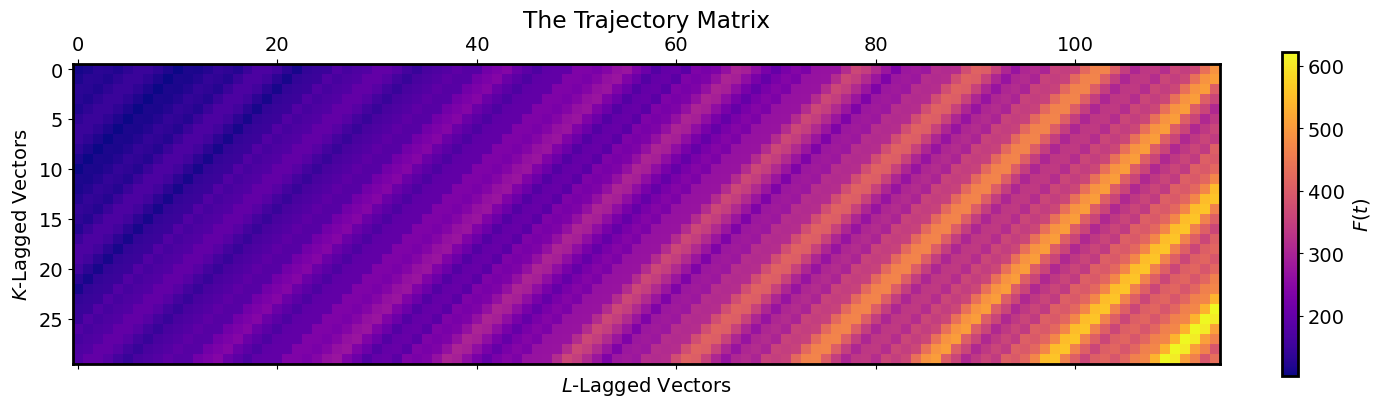

In [6]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix");

In [7]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

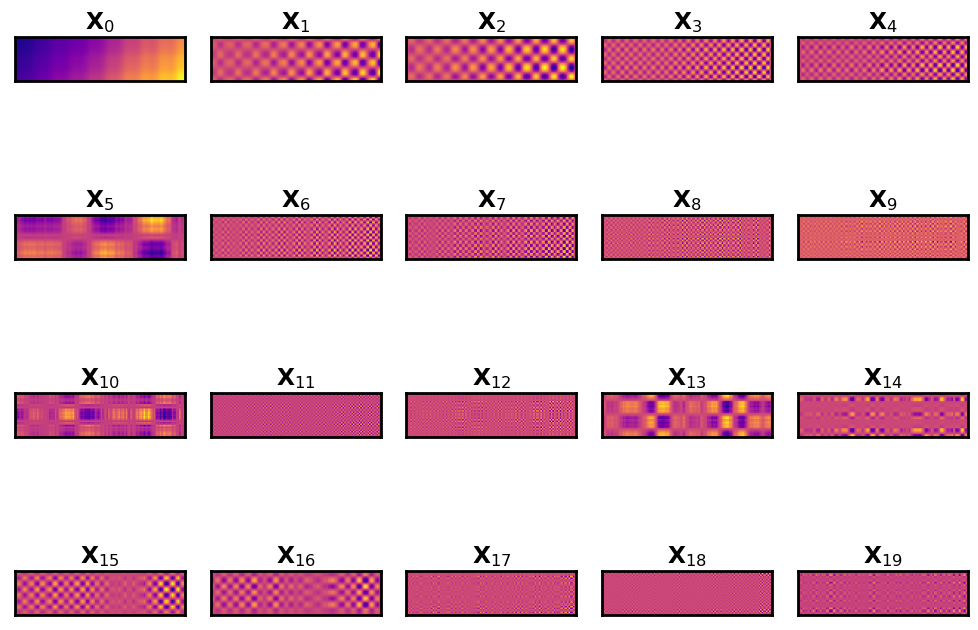

In [8]:
n = min(20, d) 
for i in range(n):
    plt.subplot(4,5,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

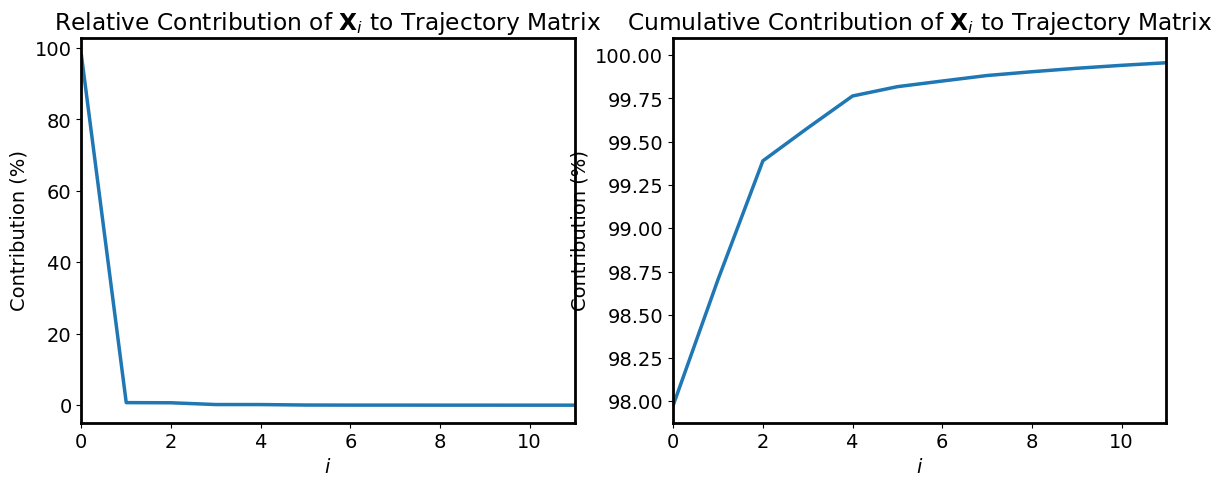

In [9]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Окееей, получаем, что 2 компонента описывают более 99% ряда, чего более, чем достаточно

In [10]:
# процесс Хенкелизации
def Hankelise(X): 
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

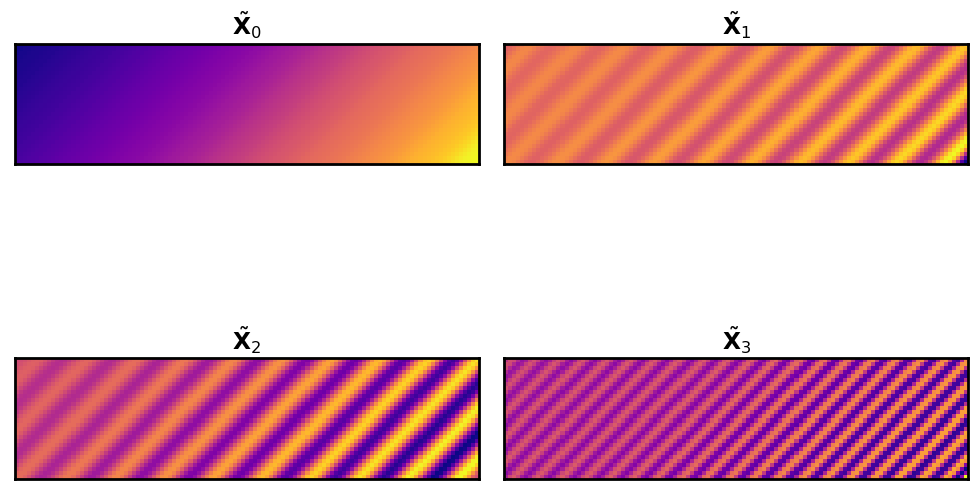

In [11]:
n = min(d, 4)
for j in range(0,n):
    plt.subplot(2,2,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

Как мы уже знаем нам полезны только 2 первые компоненты, но можем посмотреть и на большее количество, с большой долей вероятности они будут сильно скоррелированы

In [12]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [13]:
t = np.arange(0,144)

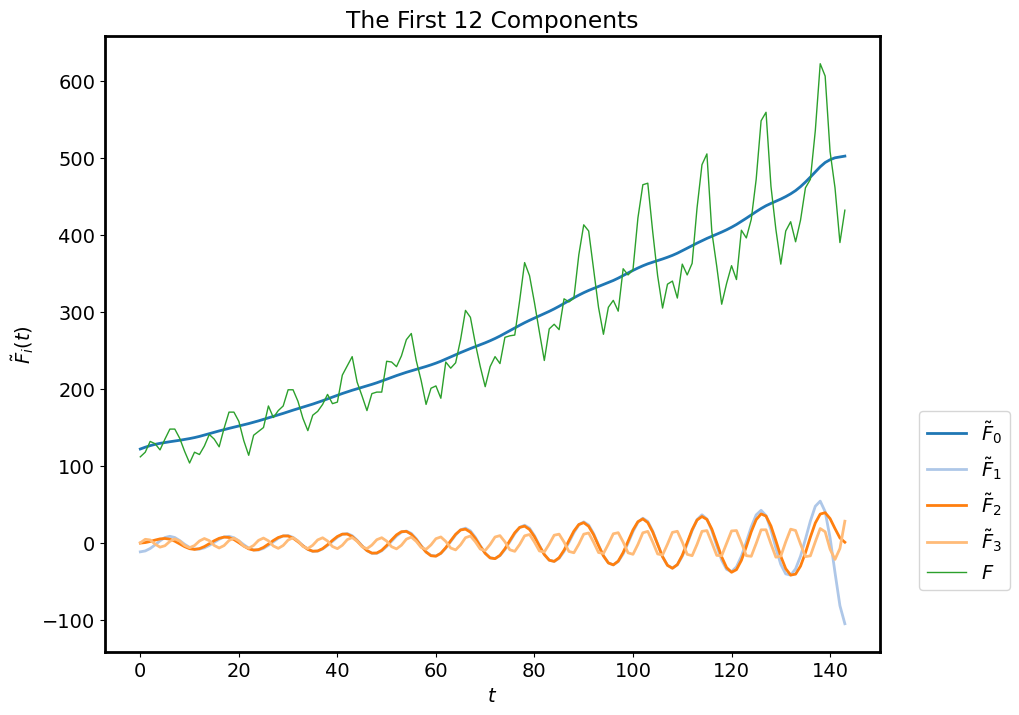

In [14]:
n = min(4,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components")
fig.legend(legend, loc=(1.05,0.1));

In [15]:
F_1_2 = X_to_TS(X_elem[[0,1]].sum(axis=0))
F_12 = X_to_TS(X_elem[[0,1,2,3,4,5,6,7,8,9,10,11]].sum(axis=0))

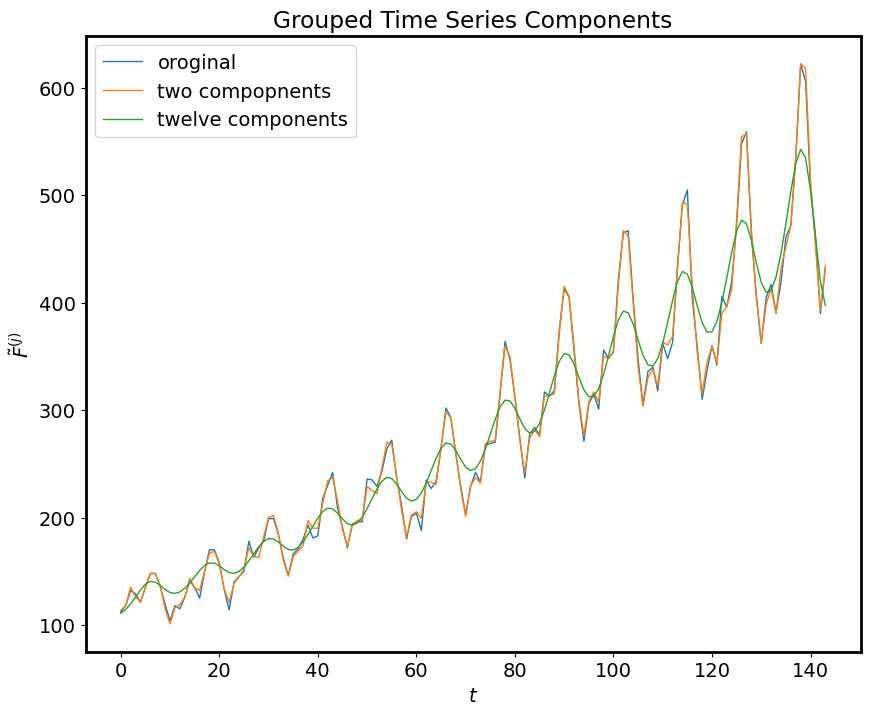

In [16]:
plt.plot(t, series, lw=1)
plt.plot(t, F_12, lw=1)
plt.plot(t, F_1_2, lw=1)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ['oroginal', 'two compopnents', 'twelve components']
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

w-корреляционная матрица для временного ряда

In [17]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

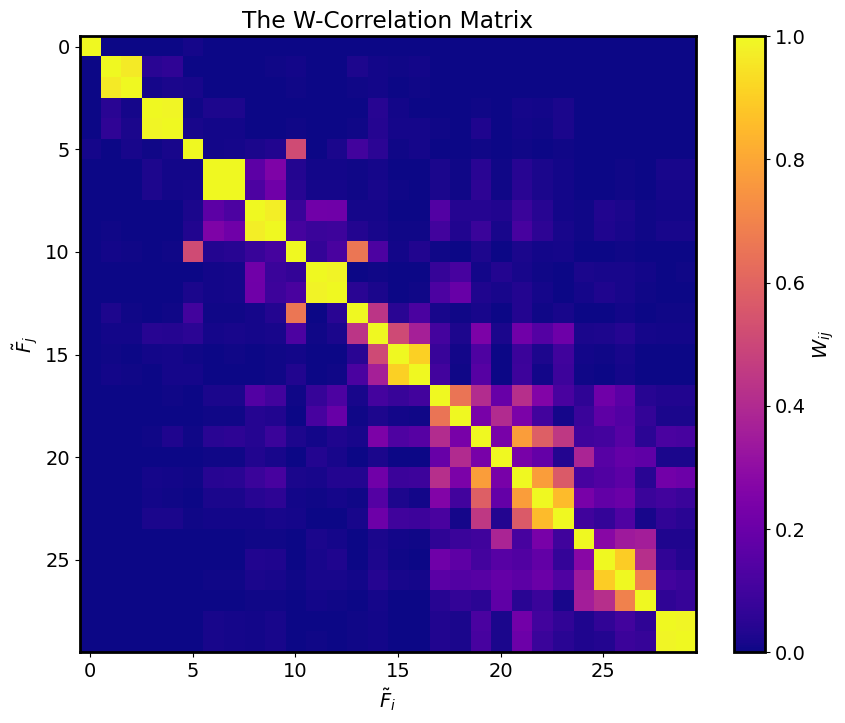

In [18]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix");

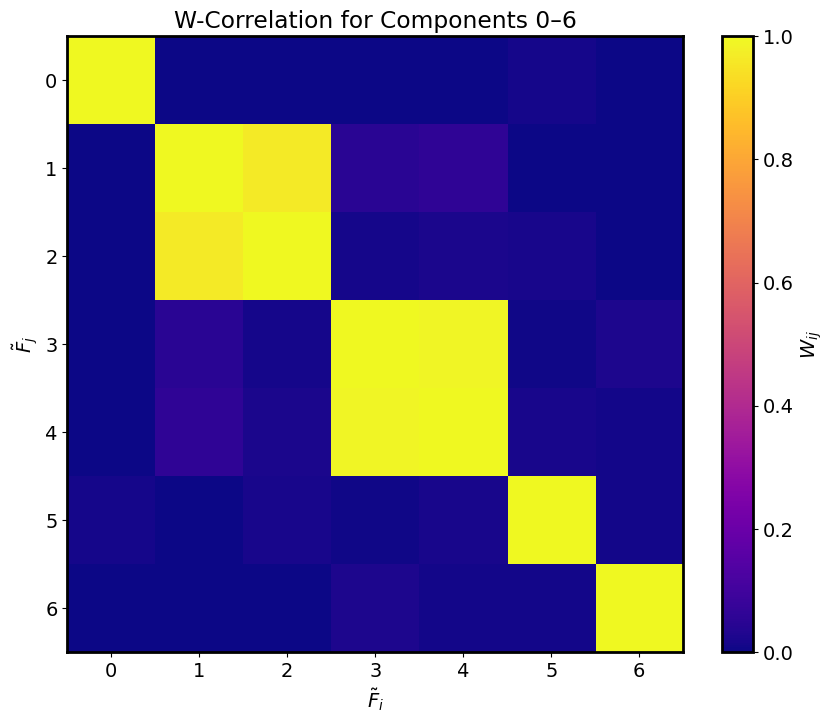

In [19]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6");

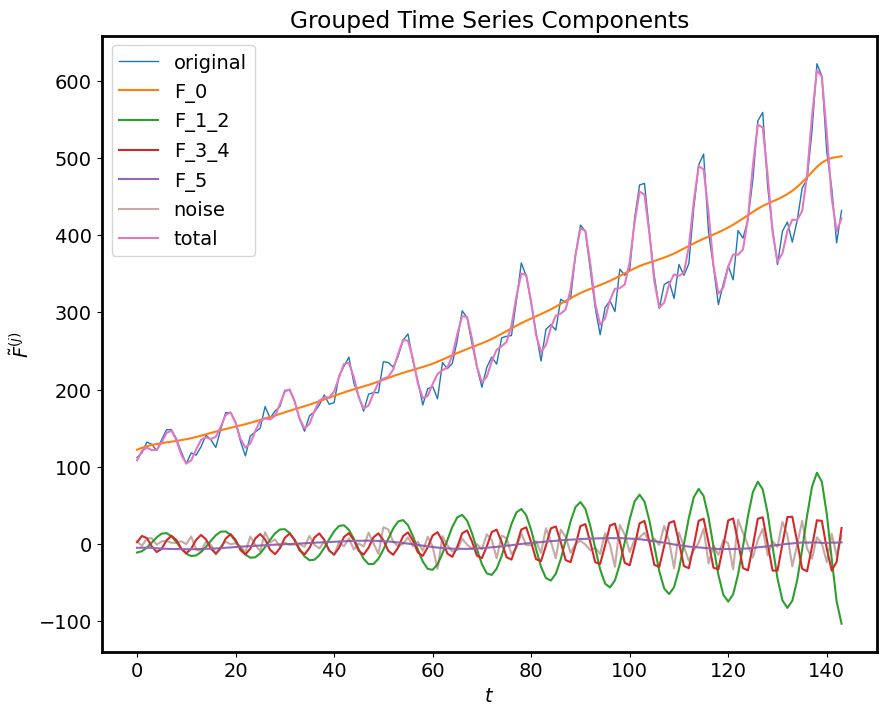

In [20]:
F_0 = X_to_TS(X_elem[[0]].sum(axis=0))
F_1_2 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_3_4 = X_to_TS(X_elem[[3,4]].sum(axis=0))
F_5 = X_to_TS(X_elem[[5]].sum(axis=0))
F_noise = X_to_TS(X_elem[6:].sum(axis=0))
F_total = X_to_TS(X_elem[[0,1,2,3,4,5]].sum(axis=0))

plt.plot(t, series, lw=1)
plt.plot(t, F_0)
plt.plot(t, F_1_2)
plt.plot(t, F_3_4)
plt.plot(t, F_5)
plt.plot(t, F_noise, alpha=0.5)
plt.plot(t, F_total)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
legend = ['original', 'F_0', 'F_1_2', 'F_3_4', 'F_5', 'noise', 'total']
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

Text(0.5, 1.0, '$L=2$ ')

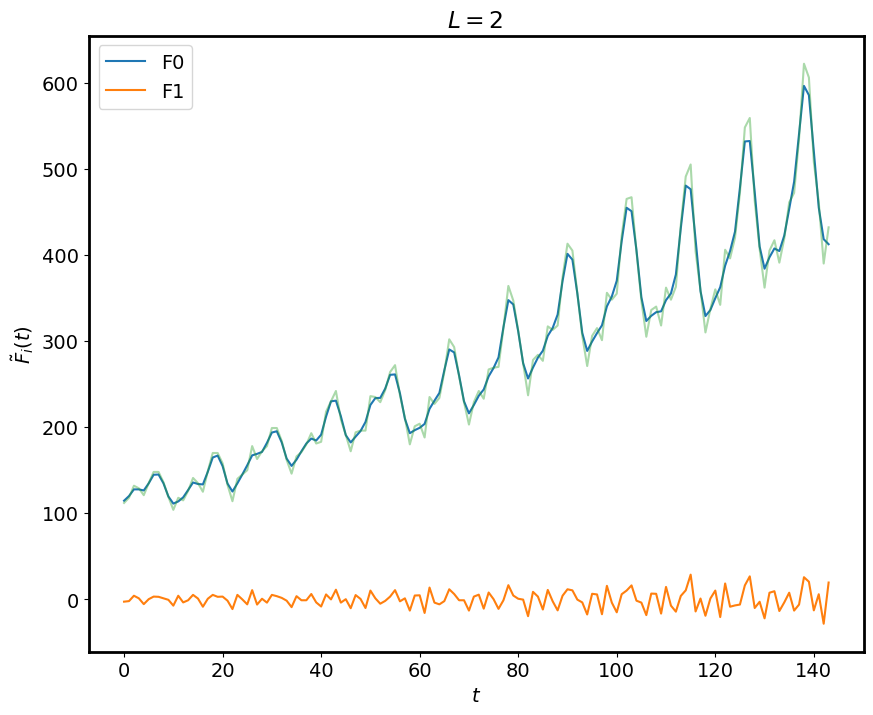

In [21]:
F_ssa_L2 = SSA(series, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ ")

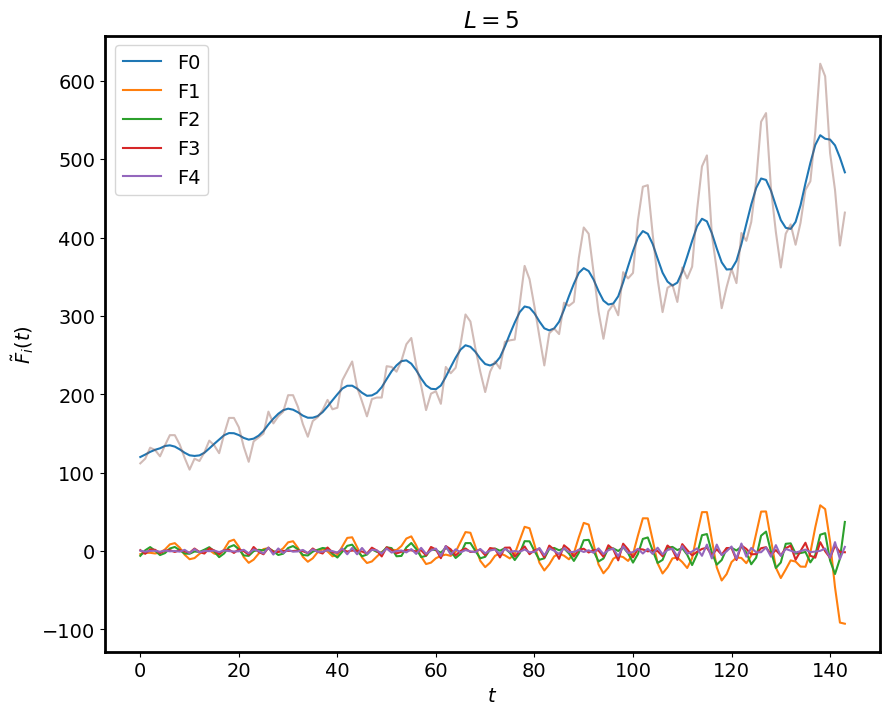

In [22]:
F_ssa_L5 = SSA(series, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ ")
plt.show()

Text(0.5, 1.0, 'W-Correlation for Time Series, $L=20$')

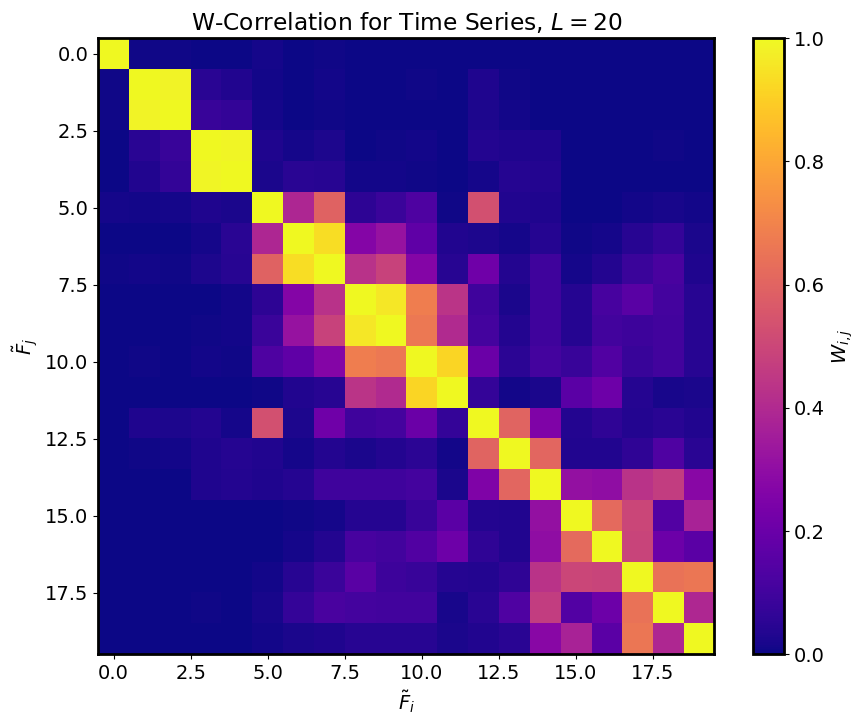

In [23]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Time Series, $L=20$")

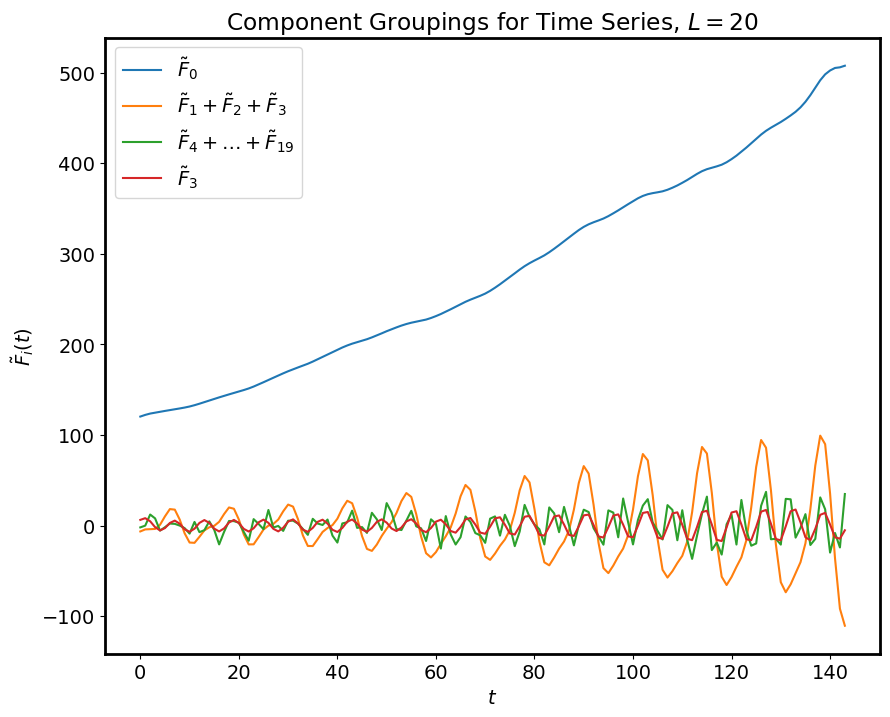

In [24]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Time Series, $L=20$")
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$",
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);